# Network analysis in the city of Beira.

### Measuring travel time from all populated places to key services:
    1) population: WorldPop, for consistency with the earlier drainage analysis for this same location.
    2) commercial center: downtown. (“Praça do Município da Beira” (-19.834084150189714, 34.83575811502723)).
    3) markets: OpenStreetMap markets where amenity='marketplace' OR 'supermarket'
    4) medical facilities: OpenStreetMap hospitals and clinics
    5) education: OpenStreetMap K-12 schools. 
    6) road network: OpenStreetMap roads and footpaths, with modifications from before (A) and after (B) the infrastructure project.

#### Travel time:
    A) Driving time before the infrastructure rehabilitation project from closest road node to population cell (dataset 1), to the closest road node to a destination (datasets 2-5) (closeness measured by road segments speeds).
    
    B) Driving time after the infrastructure rehabilitation project from closest road node to population cell (dataset 1), to the closest road node to a destination (datasets 2-5) (closeness measured by road segments speeds). 

#### Unmeasured aspects:
The following should be considered in more sophisticated iterations of the model:
    1) walking time from population cell to the closest road node.
    2) disrupt the network with a flood scenario.
    3) disrupt the network with pre- and post-project bridge status.
    
Services are expected to be proximal to the road network, so no measure is taken between road and service.


### The outputs:
Each populated cell has 2 travel time values per facility: the time it takes to get to the facility before and after the infrastructure project. Population-adjusted aggregation to the EA level can be performed in R.

In [2]:
import os, sys
GISFolder = os.getcwd()
GISFolder

'/Users/csolisu/Documents/Carla/chamba/beira/beira'

In [3]:
import sys
sys.version

'3.7.0 (v3.7.0:1bf9cc5093, Jun 26 2018, 23:26:24) \n[Clang 6.0 (clang-600.0.57)]'

In [4]:
from platform import python_version

print(python_version())

3.7.0


In [5]:
# load and filter osm network (step 1)
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import time
import GOSTnets as gn
import networkx as nx
import osmnx as ox
import numpy as np
import rasterio as rt
import shapely
from shapely.geometry import Point, box
from shapely.ops import unary_union
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Point

# Might not use these
import fiona
import peartree
#import gdal
import importlib
import matplotlib.pyplot as plt
import subprocess, glob


Bad key savefig.frameon in file /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.

In [6]:
pth_points = "/Users/csolisu/Documents/Carla/chamba/beira/beira/data/points_destiny"
pth_points

temp = "/Users/csolisu/Documents/Carla/chamba/beira/temp/"

### Prepare and clean the data

In [7]:
# OSM road network is in WGS84. Projected each dataset to match.
# Multi-point shapefiles don't read well. Re-created shapefile from csv with geopandas for each offending file.
##Putting all our destinations in a same place (?)
markets_a = gpd.read_file(pth_points + "/Markets_Beira_planet_osm_point_points.shp")
markets_b = gpd.read_file(pth_points + "/markets_centroids.shp")
financial_a = gpd.read_file(pth_points + "/financial_centroids.shp")
financial_b = gpd.read_file(pth_points + "/beira_financial_planet_osm_point_points.shp")
educ_a = gpd.read_file(pth_points + "/education_centroids.shp")
educ_b = gpd.read_file(pth_points + "/education_beira_planet_osm_point_points.shp")
health_a = gpd.read_file(pth_points + "/healthcare_centroids.shp")
health_b = gpd.read_file(pth_points + "/beira_healthcare_planet_osm_point_points.shp")
downtown = gpd.read_file(pth_points + "/downtown.shp")


In [8]:
markets = pd.concat([markets_a, markets_b]).reset_index()
financial = pd.concat([financial_a, financial_b]).reset_index()
educ = pd.concat([educ_a, educ_b]).reset_index()
health = pd.concat([health_a, health_b]).reset_index()


In [9]:
hospital = health.loc[health['name'] == 'Beira Central Hospital']
schools = educ.loc[educ['amenity'] == 'school']

In [10]:
popu = gpd.read_file(pth_points + "/Population_beira_2020_worldpop.shp")

popu.drop(popu.loc[popu['Z'] == '-99999'].index, inplace = True)
popu = popu.reset_index()
popu = popu.drop(columns = ['index'])

popu['Z'] = pd.to_numeric(popu['Z'], errors = 'coerce')
mult = 533825/popu['Z'].sum()
popu['Z'] = popu['Z'] * mult



In [11]:
beira_city = gpd.read_file("/Users/csolisu/Documents/Carla/chamba/Beira accesibility/EA admin maps/BANCO MUNDIAL/CIDADE DA BEIRA/CIDADEDABEIRA.shp")


In [12]:
bairros = beira_city.loc[(beira_city['Bairro'] == 'Maraza'
)| (beira_city['Bairro'] == 'Munhava'
)| (beira_city['Bairro'] == 'Mananga'
)| (beira_city['Bairro'] == 'Matacuane'
)| (beira_city['Bairro'] == 'Esturro'
)| (beira_city['Bairro'] == 'Chipangara'
)| (beira_city['Bairro'] == 'Macurungo')]

In [13]:
bairros = bairros.to_crs("epsg:4326")
bairros.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
new_roads = pd.read_csv("https://raw.githubusercontent.com/ccsuehara/beira/main/data/osm_info_about_roads.csv")

In [16]:
new_roads = new_roads[['index', 'h_before', 'h_after']]

In [17]:
popu.crs = "epsg:4326"
popu.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
pop = gpd.sjoin(popu, bairros, how = "left", op='intersects')
pop.Bairro.value_counts()
pop = pop.loc[pop.Bairro.notna()]
pop = pop[['Z', 'geometry', 'Bairro']].reset_index()
pop = pop.drop(columns = ['index'])

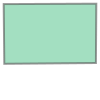

In [19]:
clip = gpd.read_file("/Users/csolisu/Documents/Carla/chamba/beira/just_beira.shp")
bound = clip.geometry.iloc[0]
bound 

In [20]:
gDrive = ox.graph_from_polygon(bound, network_type= 'all')


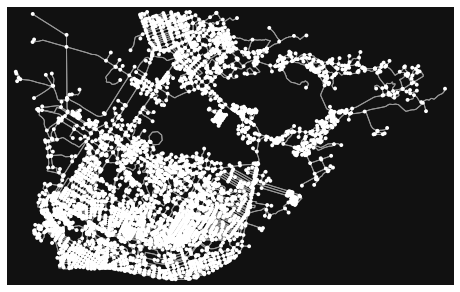

In [21]:
gDrive = ox.project_graph(gDrive, to_crs='epsg:4326')
fig, ax = ox.plot_graph(gDrive)

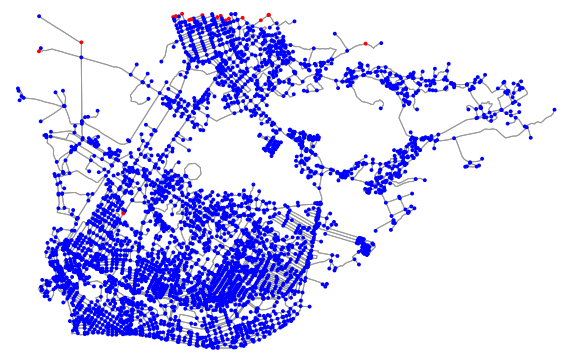

In [22]:
nc = ['b' if ox.simplification._is_endpoint(gDrive, node) else 'r' for node in gDrive.nodes()]
fig, ax = ox.plot_graph(gDrive, node_color=nc, node_zorder=3, bgcolor='#FFFFFF',figsize=(10, 10))

In [23]:
gDrive_node_gdf = gn.node_gdf_from_graph(gDrive)
gDrive_edge_gdf = gn.edge_gdf_from_graph(gDrive)

In [24]:
gDrive_edge_gdf['index'] = gDrive_edge_gdf.index

In [25]:
#Creating edges for "before"
edge_before =   pd.merge(gDrive_edge_gdf, new_roads[['index', 'h_before']]
                  , how ='left', on = 'index')

In [29]:
edge_before.loc[edge_before.h_before.notna()].h_before.value_counts()

pedestrian_road    32
paved_road_b       29
p_before           13
dirt_road          13
pv_before           3
nothing             1
Name: h_before, dtype: int64

In [30]:
#Creating edges for "after"
edge_after =   pd.merge(gDrive_edge_gdf, new_roads[['index', 'h_after']]
                  , how ='left', on = 'index')

In [31]:
edge_after.loc[edge_after.h_after.notna()].h_after.value_counts()

paved_road      48
access_works    26
pv_after         9
p_after          8
Name: h_after, dtype: int64

In [32]:
#edges_and_nodes_csv_to_graph, which are necessary to make a new graph. 
gDrive_edge_gdf.to_csv(temp + "drive_edge.csv")
gDrive_node_gdf.to_csv(temp + "drive_node.csv")

In [33]:
#Replace the merged values into our "highway" info
edge_before.loc[edge_before.h_before.notna(), 'highway'] = edge_before['h_before']
edge_after.loc[edge_after.h_after.notna(), 'highway'] = edge_after['h_after']

In [34]:
#Defining a function that cleans the obs that have more than 2 types
def clean_thing(x):
  '''
  cleans list into just a string. 
  takes either list or string, if its string it takes the second string element. 
  outputs the clean thing 
  '''
  if type(x) == list:
    a = x[1]
  else:
    a = x
  return a

In [35]:
#edge_before.loc[edge_before.h_before.notna()]

edge_before['highway'] = edge_before['highway'].apply(lambda x: clean_thing(x))
edge_before['highway'].value_counts()

residential        6402
service            1425
path                948
unclassified        875
tertiary            800
secondary           408
track               219
trunk                99
tertiary_link        35
pedestrian_road      32
paved_road_b         29
footway              22
trunk_link           17
p_before             13
dirt_road            13
pedestrian           10
living_street         4
pv_before             3
secondary_link        3
nothing               1
Name: highway, dtype: int64

In [36]:
edge_after['highway'] = edge_after['highway'].apply(lambda x: clean_thing(x))
edge_after['highway'].value_counts()

residential       6402
service           1425
path               948
unclassified       875
tertiary           800
secondary          408
track              219
trunk               99
paved_road          48
tertiary_link       35
access_works        26
footway             22
trunk_link          17
pedestrian          10
pv_after             9
p_after              8
living_street        4
secondary_link       3
Name: highway, dtype: int64

In [37]:
#saving our new before and after edges files, so we can pass them to the graph constructor later on . 
edge_before.to_csv(temp + "edge_before.csv")
edge_after.to_csv(temp + "edge_after.csv")

In [42]:
speed_dict = {
                'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':30,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20,
              ##New for Beira:
                'pedestrian_road': 0.01,
                'service': 15,
                'path': 13,
                'track': 18,
                'footway': 5,
                'pedestrian': 0.01,
                'paved_road_b': 20,
                'living_street': 10,
                'access_works': 15,
                'paved_road': 30,
                'dirt_road': 10, 
                'pv_before': 15, 
                'nothing': 0.01,
                'p_before': 0.01,
                 'pv_after':20,
                 'p_after': 0.01
                }


In [43]:
gTime = gn.convert_network_to_time(gDrive, distance_tag = 'length', graph_type = 'drive', speed_dict = speed_dict)

In [44]:
#Making our graphs 
G_b = gn.edges_and_nodes_csv_to_graph(temp + "drive_node.csv", 
                                      temp+ "edge_before.csv", 
                                      u_tag = 'stnode', v_tag = 'endnode', geometry_tag = 'geometry', largest_G = False)
G_a = gn.edges_and_nodes_csv_to_graph(temp + "drive_node.csv",
                                      temp+ "edge_after.csv",
                                       u_tag = 'stnode', v_tag = 'endnode', geometry_tag = 'geometry', largest_G = False)

In [45]:
#Converting both our graphs to time networks
gTime_b = gn.convert_network_to_time(G_b, distance_tag = 'length', graph_type = 'drive', speed_dict = speed_dict)
gTime_a = gn.convert_network_to_time(G_a, distance_tag = 'length', graph_type = 'drive', speed_dict = speed_dict)

In [46]:
#Closest point to the network
pop_snap = gn.pandana_snap(gTime_b, pop, add_dist_to_node_col = True)
pop_snap.to_csv(temp + 'pop_snap.csv', index=True)


In [47]:
#Travel times for before, for destinations
markets_snap = gn.pandana_snap(gTime_b, markets, add_dist_to_node_col = True)
markets_snap.to_csv(temp + 'markets_snap.csv', index=True)

hosp_snap = gn.pandana_snap(gTime_b, hospital, add_dist_to_node_col = True)
hosp_snap.to_csv(temp + 'hosp_snap.csv', index=True)

financial_snap = gn.pandana_snap(gTime_b, financial, add_dist_to_node_col = True)
financial_snap.to_csv(temp + 'financial_snap.csv', index=True)

school_snap = gn.pandana_snap(gTime_b, schools, add_dist_to_node_col = True)
school_snap.to_csv(temp + 'schools_snap.csv', index=True)

downtown_snap = gn.pandana_snap(gTime_b, downtown, add_dist_to_node_col = True)
downtown_snap.to_csv(temp + 'downtown_snap.csv', index=True)

In [ ]:
#pop_snap = pd.read_csv(temp + 'pop_snap.csv')
#markets_snap = pd.read_csv(temp + 'markets_snap.csv')
#hosp_snap = pd.read_csv(temp + 'hosp_snap.csv')

#financial_snap = pd.read_csv(temp + 'financial_snap.csv')
#school_snap = pd.read_csv(temp + 'schools_snap.csv')
#downtown_snap = pd.read_csv(temp + 'downtown_snap.csv')

In [48]:
##Making lists of all of the nodes closest to destinations
l_origins = list(pop_snap.NN.unique())
l_markets = list(markets_snap.NN.unique()) 
l_financial = list(financial_snap.NN.unique()) 
l_school = list(school_snap.NN.unique()) 
l_downtown = list(downtown_snap.NN.unique()) 
l_hosp = list(hosp_snap.NN.unique()) 

l_dest = l_markets + l_financial + l_school + l_downtown + l_hosp
l_dest = list(set(l_dest)) 


In [49]:
fail_value = 999999999

In [52]:
gn.example_edge(gTime_b)


(0, 1, {'Wkt': <shapely.geometry.linestring.LineString object at 0x7fe3b9e30908>, 'Unnamed: 0': 0, 'lanes': nan, 'tunnel': nan, 'junction': nan, 'ref': nan, 'maxspeed': 60.0, 'oneway': False, 'access': nan, 'name': 'Ava Mártires da Revolução', 'osmid': '820923407', 'bridge': nan, 'service': nan, 'length': 69.433, 'highway': 'secondary', 'index': 0, 'h_before': nan, 'time': 8.33196, 'mode': 'drive'})


In [53]:
OD_b = gn.calculate_OD(gTime_b, l_origins, l_dest, fail_value, weight = 'time')


In [54]:
OD_a = gn.calculate_OD(gTime_a, l_origins, l_dest, fail_value, weight = 'time')


In [55]:
OD_df_b = pd.DataFrame(OD_b, index = l_origins, columns = l_dest)
OD_df_a = pd.DataFrame(OD_a, index = l_origins, columns = l_dest)




In [56]:
OD_df_b_min = OD_df_b[OD_df_b <fail_value] / 60
OD_df_a_min = OD_df_a[OD_df_a <fail_value] / 60


l_markets = list(markets_snap.NN.unique()) 
l_financial = list(financial_snap.NN.unique()) 
l_school = list(school_snap.NN.unique()) 
l_downtown = list(downtown_snap.NN.unique()) 
l_hosp = list(hosp_snap.NN.unique())


In [57]:
# Create POI-specific OD and save to file.
OD_markets = OD_df_b.loc[:, l_markets]
OD_markets = OD_markets[OD_markets < fail_value] / 60 

OD_financial = OD_df_b.loc[:, l_financial]
OD_financial = OD_financial[OD_financial < fail_value] / 60 

OD_school = OD_df_b.loc[:, l_school]
OD_school = OD_school[OD_school < fail_value] / 60 

OD_downtown = OD_df_b.loc[:, l_downtown]
OD_downtown = OD_downtown[OD_downtown < fail_value] / 60 

OD_hosp = OD_df_b.loc[:, l_hosp]
OD_hosp = OD_hosp[OD_hosp < fail_value] / 60 


In [58]:
OD_markets["1M"] = 0
sub = OD_markets.iloc[:,0:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_markets["1M"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
M1 = OD_markets[['1M']]
M1['NN'] = M1.index
 # Remove unnecessary OD values.
#D1.to_csv(os.path.join(pth, '1D_base.csv'))

In [59]:
OD_financial["1F"] = 0
sub = OD_financial.iloc[:,0:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_financial["1F"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
F1 = OD_financial[['1F']]
F1['NN'] = F1.index

In [60]:
OD_downtown["1D"] = 0
sub = OD_downtown.iloc[:,0:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_downtown["1D"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
D1 = OD_downtown[['1D']]
D1['NN'] = D1.index

In [61]:
OD_school["1S"] = 0
sub = OD_school.iloc[:,0:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_school["1S"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
S1 = OD_school[['1S']]
S1['NN'] = S1.index

In [62]:
OD_hosp["1H"] = 0
sub = OD_hosp.iloc[:,0:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_hosp["1H"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
H1 = OD_hosp[['1H']]
H1['NN'] = H1.index

In [63]:
# Create POI-specific OD and save to file.
OD_markets_a = OD_df_a.loc[:, l_markets]
OD_markets_a = OD_markets_a[OD_markets_a < fail_value] / 60 

OD_financial_a = OD_df_a.loc[:, l_financial]
OD_financial_a = OD_financial_a[OD_financial_a < fail_value] / 60 

OD_school_a = OD_df_a.loc[:, l_school]
OD_school_a = OD_school_a[OD_school_a < fail_value] / 60 

OD_downtown_a = OD_df_a.loc[:, l_downtown]
OD_downtown_a = OD_downtown_a[OD_downtown_a < fail_value] / 60 

OD_hosp_a = OD_df_a.loc[:, l_hosp]
OD_hosp_a = OD_hosp_a[OD_hosp_a < fail_value] / 60 

In [64]:
OD_markets_a["1Ma"] = 0
sub = OD_markets_a.iloc[:,0:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_markets_a["1Ma"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
#M1_a = OD_markets_a[['1Ma']]
#M1_a['NN'] = M1.index

OD_financial_a["1Fa"] = 0
sub = OD_financial_a.iloc[:,0:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_financial_a["1Fa"] = sub.min(axis=1) 

OD_school_a["1Sa"] = 0
sub = OD_school_a.iloc[:,0:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_school_a["1Sa"] = sub.min(axis=1)

OD_hosp_a["1Ha"] = 0
sub = OD_hosp_a.iloc[:,0:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_hosp_a["1Ha"] = sub.min(axis=1)

OD_downtown_a["1Da"] = 0
sub = OD_downtown_a.iloc[:,0:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_downtown_a["1Da"] = sub.min(axis=1) 

In [65]:
all_times = OD_financial[['1F']]
all_times['1M'] = OD_markets['1M']
all_times['1H'] = OD_hosp['1H']
all_times['1S'] = OD_school['1S']
all_times['1D'] = OD_downtown['1D']

all_times['1Ma'] = OD_markets_a['1Ma']
all_times['1Fa'] = OD_financial_a['1Fa']
all_times['1Ha'] = OD_hosp_a['1Ha']
all_times['1Sa'] = OD_school_a['1Sa']
all_times['1Da'] = OD_downtown_a['1Da']

In [66]:
all_times['NN'] = all_times.index

In [67]:
all_times = all_times.merge(pop_snap, how = 'inner', on = 'NN')

In [68]:
all_times['better_F'] = np.where(all_times['1F'] > all_times['1Fa'],1,0)
all_times['better_H'] = np.where(all_times['1H'] >all_times['1Ha'],1,0)
all_times['better_S'] = np.where(all_times['1S'] > all_times['1Sa'],1,0)
all_times['better_D'] = np.where(all_times['1D'] > all_times['1Da'],1,0)
all_times['better_M'] = np.where(all_times['1M'] > all_times['1Ma'],1,0)

In [69]:
## How many people benefited. ? 
all_times['bn_F'] = all_times['Z'] * all_times['better_F']
all_times['bn_H'] = all_times['Z'] * all_times['better_H']
all_times['bn_S'] = all_times['Z'] * all_times['better_S']
all_times['bn_D'] = all_times['Z'] * all_times['better_D']
all_times['bn_M'] = all_times['Z'] * all_times['better_M']

all_times['T_Fb'] = all_times['Z'] * all_times['1F']
all_times['T_Hb'] = all_times['Z'] * all_times['1H']
all_times['T_Sb'] = all_times['Z'] * all_times['1S']
all_times['T_Db'] = all_times['Z'] * all_times['1D']
all_times['T_Mb'] = all_times['Z'] * all_times['1M']

all_times['T_Fa'] = all_times['Z'] * all_times['1Fa']
all_times['T_Ha'] = all_times['Z'] * all_times['1Ha']
all_times['T_Sa'] = all_times['Z'] * all_times['1Sa']
all_times['T_Da'] = all_times['Z'] * all_times['1Da']
all_times['T_Ma'] = all_times['Z'] * all_times['1Ma']


##How much time they saved ? 

In [70]:
all_times[['better_F', '1F', '1Fa', 'T_Fa', 'T_Fb']]

better_F         1F        1Fa        T_Fa        T_Fb
0            0  12.935592  12.935592  147.205706  147.205706
1            0  12.935592  12.935592  171.727244  171.727244
2            0  12.935592  12.935592  172.717808  172.717808
3            0  12.935592  12.935592  175.574080  175.574080
4            0  12.935592  12.935592  175.620436  175.620436
...        ...        ...        ...         ...         ...
2589         1   3.786512   3.646563  302.766535  314.386209
2590         1   3.842582   3.702633  307.623148  319.250429
2591         0   3.375293   3.375293  283.548347  283.548347
2592         1   3.550812   3.493835  288.490578  293.195244
2593         0   3.176912   3.176912  261.928689  261.928689

[2594 rows x 5 columns]

In [71]:
benefitted = all_times.groupby(['Bairro']).agg(b_financial=('bn_F', 'sum'),
b_hosp=('bn_H', 'sum'),
b_school=('bn_S', 'sum'),
b_downtown = ('bn_D', 'sum'),
b_market = ('bn_M', 'sum'),
people = ('Z', 'sum'))

In [72]:
benefitted.to_csv(temp + 'benefit.csv')

In [73]:
time_saved = all_times.groupby(['Bairro']).agg(T_Fb=('T_Fb', 'sum'),
T_Hb=('T_Hb', 'sum'),
T_Sb=('T_Sb', 'sum'),
T_Db = ('T_Db', 'sum'),
T_Mb = ('T_Mb', 'sum'),
T_Fa=('T_Fa', 'sum'),
T_Ha=('T_Ha', 'sum'),
T_Sa=('T_Sa', 'sum'),
T_Da = ('T_Da', 'sum'),
T_Ma = ('T_Ma', 'sum'))

In [74]:
time_F = all_times.loc[all_times['better_F'] == 1].groupby(['Bairro']).agg(T_Fb=('T_Fb', 'sum'),
T_Fa=('T_Fa', 'sum'))

time_H = all_times.loc[all_times['better_H'] == 1].groupby(['Bairro']).agg(T_Hb=('T_Hb', 'sum'),
T_Ha=('T_Ha', 'sum'))

time_D = all_times.loc[all_times['better_D'] == 1].groupby(['Bairro']).agg(T_Db=('T_Db', 'sum'),
T_Da=('T_Da', 'sum'))

time_S = all_times.loc[all_times['better_S'] == 1].groupby(['Bairro']).agg(T_Sb=('T_Sb', 'sum'),
T_Sa=('T_Sa', 'sum'))

time_M = all_times.loc[all_times['better_M'] == 1].groupby(['Bairro']).agg(T_Mb=('T_Mb', 'sum'),
T_Ma=('T_Ma', 'sum'))

In [75]:
times = pd.concat([time_F, time_H, time_D, time_S, time_M], axis=1)

In [76]:
times.to_csv(temp + "times.csv")

In [77]:
all_times.to_csv(temp + "all_times.csv")

In [110]:
temp

'/Users/csolisu/Documents/Carla/chamba/beira/temp/'

In [107]:
waa = waa [['1F', '1Fa', 'Z', 'T_Fb', 'T_Fa']]

In [108]:
waa

1F       1Fa          Z        T_Fb        T_Fa
659   9.692399  9.316318  58.053873  562.681316  540.848358
660   9.692399  9.316318  46.326672  449.016600  431.594019
661   9.692399  9.316318  43.227477  418.977965  402.720932
662   9.692399  9.316318  73.412527  711.543522  683.934465
663   9.692399  9.316318  59.929869  580.864213  558.325728
...        ...       ...        ...         ...         ...
2587  3.570408  3.495197  81.047858  289.373921  283.278231
2588  3.570408  3.495197  84.669221  302.303665  295.935608
2589  3.786512  3.646563  83.027918  314.386209  302.766535
2590  3.842582  3.702633  83.082268  319.250429  307.623148
2592  3.550812  3.493835  82.571323  293.195244  288.490578

[303 rows x 5 columns]